In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import sys
import pandas as pd
import pickle

from doublet_quantifier.curvefit import *
from doublet_quantifier.models import *

In [3]:
my_path = '/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/' # path to this directory 
sys.path.append(my_path + 'functions')
from plotting_tools import *

In [4]:
# Loading pseudo-Voigt fit parameters for various temperatures
# various pickle files generated via fitting_sonora_models.ipynb
dfs = []

## can adjust the effective temperature range here
temps = [1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400]

for temp in temps:
    with open(my_path + "diamondback-data/pickle_files/parameters/t"+ str(temp) + "_parameter_df.pkl", "rb") as f:
        df = pickle.load(f)
        df["temp"] = temp * np.ones(len(df))
        dfs.append(df[df['clouds'] != 10].copy(deep=False).reset_index(drop=True)) # remove no cloud models

master_df = pd.concat(dfs, ignore_index=True)


del df

# lists of values 
gravities = [3.5, 4.0, 4.5, 5.0, 5.5]
clouds = [1,2,3,4,8]

### Plots of the shape of doublet
#### with various color coding for temperature, gravity, and clouds

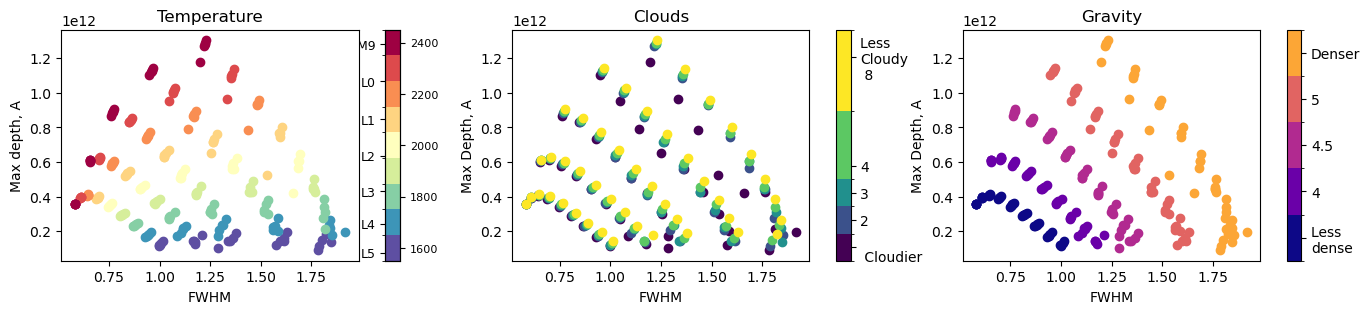

In [5]:
# setting up the plots
fig = plt.figure(figsize=(16, 3))
gs = fig.add_gridspec(1, 8, width_ratios=[1, 0.05, 0.2, 1, 0.05, 0.2,1, 0.05])
cax1, cax2, cax3= fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 4]), fig.add_subplot(gs[0, 7])
ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 3]), fig.add_subplot(gs[0, 6])

# colored by temperature
for temp in temps:
    mask = master_df['temp'] == temp
    color = temp_color(temp)
    
    ax1.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2e-3, 
               -(master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                color = color)
    
ax1.set_xlabel('FWHM')
ax1.set_ylabel('Max depth, A')
ax1.set_title('Temperature')
temp_colorbar(fig, cax = cax1, fontsize=9, labelpad=1)

# colored by fsed
for fsed in clouds:
    mask = round(master_df['clouds'], 1) == fsed
    color = fsed_color(fsed)
    
    ax2.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2e-3, 
               -(master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                color = color)
    
    
ax2.set_xlabel('FWHM')
ax2.set_ylabel('Max Depth, A')
ax2.set_title('Clouds')
fsed_colorbar(fig, cax = cax2, fontsize=10)



# colored by logg
for g in gravities:
    mask = round(master_df['logg'], 1) == g
    color = logg_color(g)
    
    ax3.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2e-3, 
               -(master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                color = color)
    
ax3.set_xlabel('FWHM')
ax3.set_ylabel('Max Depth, A')
ax3.set_title('Gravity')
logg_colorbar(fig, cax = cax3, fontsize=10)

### Recreation of the plot in the reserach note

Text(0.5, 0, 'Avg. FWHM')

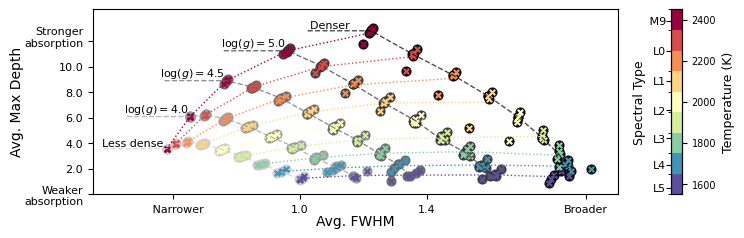

In [6]:

ticks_font_size = 8
labels_font_size = 10

## size of the plot for research note
temperature_lines = True
gravity_lines = True
annotating_gravity = True
grav_annotations =[r'$\log(g) = $' + str(g) + ' ' for g in gravities]
grav_annotations[0] = 'Less dense '
grav_annotations[-1] = 'Denser      '

# starting plot
fig = plt.figure(figsize=(7.6, 2.4))
gs = fig.add_gridspec(1, 2,width_ratios=[1, 0.02])

ax = fig.add_subplot(gs[0, 0])
cax1= fig.add_subplot(gs[0, 1])


# plotting lines for temperatures
if temperature_lines == True:
    for temp in temps:
        avg_A = []
        max_A = []
        min_A = []
        avg_FWHM = []
        mask_temp = master_df['temp'] == temp
        color = temp_color(temp)
        for g in gravities:
            mask_grav = round(master_df['logg'], 1) == g
            mask = mask_temp & mask_grav
            avg_A.append(np.mean(master_df[mask]['A1'] + master_df[mask]['A2'])/2)
            max_A.append(np.max(-(master_df[mask]['A1'] + master_df[mask]['A2']))/2)
            min_A.append(np.min(-(master_df[mask]['A1'] + master_df[mask]['A2']))/2)
            avg_FWHM.append(np.mean(master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2)
        ax.plot(avg_FWHM, -np.array(avg_A), color = color, lw = 1, alpha = 1, linestyle = 'dotted')

# plotting lines for gravity
if gravity_lines == True:
    for i, g in  enumerate(gravities):
        avg_A = []
        avg_FWHM = []
        color = logg_bw_color(g)
        mask_grav = round(master_df['logg'], 1) == g
        for temp in temps:
            mask_temp = master_df['temp'] == temp
            mask = mask_temp & mask_grav
            avg_A.append(np.median(master_df[mask]['A1'] + master_df[mask]['A2'])/2)
            avg_FWHM.append(np.median(master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2)
        
        # extending the lines and annotating the logg values
        if annotating_gravity:
            avg_A.append(avg_A[-1]) # - (avg_A[-2] - avg_A[-1]))
            avg_FWHM.append(avg_FWHM[-1] - (.2e-3))
            ax.annotate(grav_annotations[i], (avg_FWHM[-2], -avg_A[-2]), fontsize=8, color = 'k', ha='right', va='bottom')

        ax.plot(avg_FWHM, -np.array(avg_A), color = color, lw = 1, alpha = .7, linestyle = 'dashed')

        
# plotting black and white point for gravities        
for g in gravities:
    mask = round(master_df['logg'], 1) == g
    mask = mask & (master_df['temp'] >= 1400) & (master_df['logg'] <= 2400)
    color = logg_bw_color(g)
    ax.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2, 
               -(master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                color = color, s=40, alpha = .9)
    
# plotting colored points for temperatures
for temp in temps:
    mask = master_df['temp'] == temp
    color = temp_color(temp)
    ax.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2, 
                - (master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                    color = color, alpha = 1, s=15, marker = 'x')
        
        
# creating temperture colorbar
temp_cb = temp_colorbar(fig, cax = cax1, pad= 50, fontsize=ticks_font_size, shrink = 0.5, labels= True)
temp_cb.ax.tick_params(axis='both', which='major', pad=0)



# set limits and ticks for the y axis
ax.set_ylim(-20, 14.5e11)
yticks = np.array([0, 2e11, 4e11, 6e11, 8e11, 10e11, 12e11])
ylabel = list(yticks.copy()/1e11)
ylabel[-1] = "Stronger\nabsorption\n"
ylabel[0] = "Weaker\nabsorption"
ax.set_yticks(yticks)
ax.set_yticklabels(ylabel, fontsize= ticks_font_size)


# set limits and ticks for the x axis
ax.set_xlim(0.35e-3, 2.00e-3)
xticks = np.array([0.6e-3, 1e-3, 1.4e-3, 1.9e-3])
xlabel = list(np.around(xticks.copy()/1e-3, 1))
xlabel[-1] = "Broader"
xlabel[0] = "   Narrower"
ax.set_xticks(xticks)
ax.set_xticklabels(xlabel, fontsize= ticks_font_size)


# set axis labels
ax.set_ylabel("Avg. Max Depth", fontsize=labels_font_size, labelpad=0)
ax.set_xlabel("Avg. FWHM", fontsize=labels_font_size, labelpad=0) 
 